# Librerías

In [1]:
import os, math, random
# Numpy
import numpy as np
# Pytorch
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms, utils as vutils
# Matplotlib
import matplotlib.pyplot as plt

In [2]:
# Semilla aleatoria
SEED = 42

# Fijamos la semilla para Pytorch y Numpy
random.seed(SEED); np.random.seed(SEED)
torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)

"""
"acelerar" la velocidad de entrenamiento de las redes neuronales al utilizar la GPU del computador (o cambiando el Runtime Type en Colab a uno con GPU)
Si presenta errores extraños ligados a "CUDA", settea esta variable como "cpu" (todo el notebook corre sin necesidad de usar GPU).
"""
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


# Importamos el Dataset de FashonMNIST y filtramos la clase de interes

In [28]:
"""
Cambiar ID según el ítem a entrenar:
0=T-shirt/top, 1=Trouser, 2=Pullover, 3=Dress, 4=Coat, 5=Sandal, 6=Shirt, 7=Sneaker, 8=Bag, 9=Ankle boot
"""
CLASS_ID = 7
CLASS_NAMES = {
    0:"T-shirt/top", 1:"Trouser", 2:"Pullover", 3:"Dress", 4:"Coat",
    5:"Sandal", 6:"Shirt", 7:"Sneaker", 8:"Bag", 9:"Ankle boot"
}

# Definir transformaciones (convertir a tensor y normalizar valores)
transform = transforms.Compose([
    transforms.ToTensor(),               # convierte la imagen a tensor [0,1]
    transforms.Normalize((0.5,), (0.5,)) # centra valores en [-1,1]
])

# Descargar y cargar el dataset fashonMNIST
fmnist = datasets.FashionMNIST(root="./data", train=True, download=True, transform=transform)

# Filtrar solo la clase del ID
indices_cls = [i for i, y in enumerate(fmnist.targets) if int(y)==CLASS_ID]
fmnist_cls = Subset(fmnist, indices_cls)
batch_size = 128
dataloader = DataLoader(fmnist_cls, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)


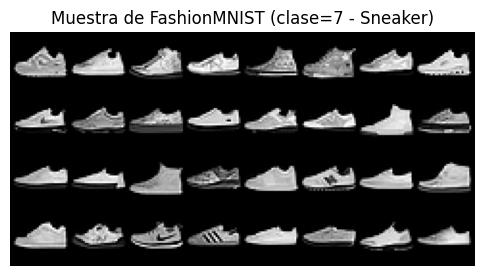

In [30]:
# vista rápida (deberían verse ejemplares del elemento elegido)
batch = next(iter(dataloader))[0][:32]
grid = vutils.make_grid(batch, nrow=8, normalize=True, value_range=(-1,1))
plt.figure(figsize=(6,6)); plt.axis("off")
plt.imshow(grid.permute(1,2,0).cpu())
plt.title(f"Muestra de FashionMNIST (clase={CLASS_ID} - {CLASS_NAMES[CLASS_ID]})")
plt.show()

# Formulas, parametros y erramientas para los tensores

In [5]:
# Hiperparámetros de difusión (DDPM) del paper

T = 1000                                                                        # pasos de difusión (1000 si hay paciencia)
beta_start, beta_end = 1e-4, 2e-2
betas = torch.linspace(beta_start, beta_end, T, dtype=torch.float32).to(device) # cuanto ruido nuevo se agrega en cada paso. crece linealmente

alphas = 1.0 - betas                                                 # cuanto se "conserva” de la señal previa en cada paso // fracción de señal que sobrevive
alphas_cumprod = torch.cumprod(alphas, dim=0)                        # pitatoria de los alphas hasta cad tiempo (tensor tambien) // cuánta señal original queda después de t pasos
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1,0), value=1.0)   # Ajuste para casos borde // agrega algunos 1.0 al tensor en los b0rdes poder operar

sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)                  # raiz del tensor alpha acumulado
sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - alphas_cumprod)  # raiz del tensor beta acumulado
sqrt_recip_alphas = torch.sqrt(1.0/alphas)                        # raiz del inverso de alpha acumulado

posterior_variance = betas * (1.0 - alphas_cumprod_prev) / (1.0 - alphas_cumprod)   # \tilde{β}_t, varianza de 𝑞(𝑥_{𝑡−1}∣𝑥_𝑡,𝑥_0); para muestrear en el reverse (añadir el ruído correcto)

def extract(a, t, x_shape):
    """
    Extrae a[t] y lo da forma (B,1,1,1) para broadcast.
    t: (B,) int64
    """
    out = a.gather(-1, t).float()
    return out.view(-1, 1, 1, 1).expand(x_shape)

def q_sample(x_start, t, noise=None):
    """
    x_t = sqrt(alphacum[t])*x0 + sqrt(1 - alphacum[t])*ε , ε∼𝑁(0,𝐼) (noise)
    para generar “imagen con ruido de nivel t” sin simular paso a paso
    """
    if noise is None:
        noise = torch.randn_like(x_start)
    return extract(sqrt_alphas_cumprod, t, x_start.shape) * x_start + \
           extract(sqrt_one_minus_alphas_cumprod, t, x_start.shape) * noise

# Red ("mini")

In [6]:
# Modelo: UNet mini para imágenes de 28x28
class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
    def forward(self, t):
        # Embedding sinusoidal estándar: convierte t en un vector de dimensión 'dim'
        # t: (B,) enteros en [0, T-1] -> float
        device = t.device
        half = self.dim // 2
        freqs = torch.exp(-math.log(10000) * torch.arange(0, half, dtype=torch.float32, device=device) / half)
        args = t.float().unsqueeze(1) * freqs.unsqueeze(0)
        emb = torch.cat([torch.sin(args), torch.cos(args)], dim=-1)
        return emb  # (B, dim)

class TimeEmbedding(nn.Module):
    def __init__(self, dim, out_dim):
        # Proyecta el embedding sinusoidal a una representación mejor para la UNet
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(dim, out_dim),
            nn.SiLU(),
            nn.Linear(out_dim, out_dim)
        )
    def forward(self, x):
        return self.mlp(x)

class ResBlock(nn.Module):
    def __init__(self, in_ch, out_ch, time_dim):
        super().__init__()
        # Bloque residual con normalización por grupos y modulación dependiente del tiempo
        self.norm1 = nn.GroupNorm(8, in_ch)
        self.act1  = nn.SiLU()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
        self.norm2 = nn.GroupNorm(8, out_ch)
        self.act2  = nn.SiLU()
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        # Proyección del embedding de tiempo al número de canales del bloque
        self.time_mlp = nn.Sequential(nn.SiLU(), nn.Linear(time_dim, out_ch))
        # Conexión residual adaptada si cambia el número de canales
        self.res_conv = nn.Conv2d(in_ch, out_ch, 1) if in_ch != out_ch else nn.Identity()

    def forward(self, x, t_emb):
        h = self.conv1(self.act1(self.norm1(x)))
        # Inyecta información temporal al mapa de características
        t = self.time_mlp(t_emb).unsqueeze(-1).unsqueeze(-1)
        h = h + t
        h = self.conv2(self.act2(self.norm2(h)))
        return h + self.res_conv(x)

class UNetMini(nn.Module):
    def __init__(self, img_ch=1, base_ch=32, time_dim=128):
        super().__init__()
        # Embedding de tiempo completo (sinusoidal + MLP)
        self.time_emb = nn.Sequential(
            SinusoidalPosEmb(time_dim),
            TimeEmbedding(time_dim, time_dim)
        )
        # Encoder
        self.in_conv = nn.Conv2d(img_ch, base_ch, 3, padding=1)
        self.rb1 = ResBlock(base_ch,   base_ch,   time_dim)  # 28x28
        self.down1 = nn.Conv2d(base_ch, base_ch*2, 4, stride=2, padding=1)  # 28->14
        self.rb2 = ResBlock(base_ch*2, base_ch*2, time_dim)  # 14x14
        self.down2 = nn.Conv2d(base_ch*2, base_ch*4, 4, stride=2, padding=1)  # 14->7
        self.rb3 = ResBlock(base_ch*4, base_ch*4, time_dim)  # 7x7

        # Bottleneck
        self.mid1 = ResBlock(base_ch*4, base_ch*4, time_dim)

        # Decoder
        self.up1 = nn.ConvTranspose2d(base_ch*4, base_ch*2, 4, stride=2, padding=1)  # 7->14
        self.rb4 = ResBlock(base_ch*4, base_ch*2, time_dim)  # concat skip rb2 -> ch dup
        self.up2 = nn.ConvTranspose2d(base_ch*2, base_ch, 4, stride=2, padding=1)    # 14->28
        self.rb5 = ResBlock(base_ch*2, base_ch, time_dim)   # concat skip rb1
        self.out_conv = nn.Conv2d(base_ch, img_ch, 1)

    def forward(self, x, t):
        t_emb = self.time_emb(t)  # (B, time_dim)

        x0 = self.in_conv(x)
        x1 = self.rb1(x0, t_emb)            # 28x28
        x2 = self.down1(x1)                 # 14x14
        x3 = self.rb2(x2, t_emb)            # 14x14
        x4 = self.down2(x3)                 # 7x7
        x5 = self.rb3(x4, t_emb)            # 7x7

        m  = self.mid1(x5, t_emb)

        u1 = self.up1(m)                    # 14x14
        u1 = torch.cat([u1, x3], dim=1)     # skip
        u1 = self.rb4(u1, t_emb)

        u2 = self.up2(u1)                   # 28x28
        u2 = torch.cat([u2, x1], dim=1)     # skip
        u2 = self.rb5(u2, t_emb)

        out = self.out_conv(u2)
        return out  # predicción del ruido ε

# Entrenamiento

Entrenamiento: Minimizar $𝔼_{t,x_0,ε}$[ $||ε-ε_{θ}(x_{t}, t)||^2$ ]

$𝔼_{t,x_0,ε}$[ $||ε-ε_{θ}(\sqrt{\hat{α}}·x_0+\sqrt{1-\hat{α}}·ε, t)||^2$ ]



Intuitivamente: cada parámetro de la red (los pesos de sus neuronas) es una perilla que se puede girar.\
El objetivo es girarlas en la dirección que baja la pérdida $𝔼_{t,x_0,ε}$

In [31]:
# Entrenamiento

"""
MODIFICAR:
lr = 2e-4 -> aumentar para mayor precision (avanza mas lento el decenso de gradiente, menos perdida de MSE por tanda)
epoch = 100 -> aumentar para mayor aprendizaje (demora mas el entrenamiento, mas tandas)
"""

model = UNetMini(img_ch=1, base_ch=32, time_dim=128).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-4, weight_decay=1e-4) # optimizamos con descenso de gradiente ajustado para no sobre dimensionar errores y AdamW de algoritmo

loss_step_hist = []    # loss por iteración
loss_epoch_hist = []   # promedio por época

epochs = 80      # "tandas" de entrenamiento // subir para mejor calidad // [15,50]epochs ==> [30,90]minutos
log_every = 100  # frecuencia de logging
global_step = 0
model.train()    # inicia el entrenamiento

for epoch in range(1, epochs+1):
    print(f"Epoch {epoch}/{epochs}")
    running = 0.0
    num_logged = 0
    for i, (x, _) in enumerate(dataloader):
        x = x.to(device)                                     # ya está en [-1,1] por la Normalization
        b = x.size(0)                                        # tamaño del Batch
        t = torch.randint(0, T, (b,), device=device).long()  # elige un t distinto unif para cada muestra, así el denoiser  entrena en todos los niveles
        noise = torch.randn_like(x)                          # ε∼𝑁(0,𝐼) de igual dimension q x
        x_noisy = q_sample(x, t, noise)                      # genera x_t

        pred_noise = model(x_noisy, t)        # prediccion del ruido ê
        loss = F.mse_loss(pred_noise, noise)  # Pérdida MSE entre ruido predicho y real (ε-ê)

        optimizer.zero_grad()  # Pone los gradientes acumulados en cero antes del siguiente paso
        loss.backward()        # Calcula hacia atrás qué debe ajustar // calcula los gradientes de la pérdida con respecto a todos los parámetros del modelo
        optimizer.step()       # actualizar pesos (parámetros del modelo) // Usa los gradientes para actualizar los pesos (con AdamW)

        # logging
        loss_val = loss.item()
        loss_step_hist.append(loss_val)
        running += loss_val  # Acumula running para imprimir promedios cada log_every iteraciones
        num_logged += 1
        global_step += 1
        if (i+1) % log_every == 0:
            print(f"Epoch {epoch} | step {i+1}/{len(dataloader)} | loss {running/log_every:.4f}")
            running = 0.0
            num_logged = 0

    # promedio por época
    start = len(loss_step_hist) - len(dataloader)
    loss_epoch = sum(loss_step_hist[start:]) / len(dataloader)
    loss_epoch_hist.append(loss_epoch)

# Guardar pesos
os.makedirs("ckpts", exist_ok=True)
ckpt_path = f"ckpts/ddpm_fmnist_cls{CLASS_ID}_unetmini.pt"
torch.save(model.state_dict(), ckpt_path)
print("Modelo guardado en", ckpt_path)

Epoch 1/80
Epoch 2/80
Epoch 3/80
Epoch 4/80
Epoch 5/80
Epoch 6/80
Epoch 7/80
Epoch 8/80
Epoch 9/80
Epoch 10/80
Epoch 11/80
Epoch 12/80
Epoch 13/80
Epoch 14/80
Epoch 15/80
Epoch 16/80
Epoch 17/80
Epoch 18/80
Epoch 19/80
Epoch 20/80
Epoch 21/80
Epoch 22/80
Epoch 23/80
Epoch 24/80
Epoch 25/80
Epoch 26/80
Epoch 27/80
Epoch 28/80
Epoch 29/80
Epoch 30/80
Epoch 31/80
Epoch 32/80
Epoch 33/80
Epoch 34/80
Epoch 35/80
Epoch 36/80
Epoch 37/80
Epoch 38/80
Epoch 39/80
Epoch 40/80
Epoch 41/80
Epoch 42/80
Epoch 43/80
Epoch 44/80
Epoch 45/80
Epoch 46/80
Epoch 47/80
Epoch 48/80
Epoch 49/80
Epoch 50/80
Epoch 51/80
Epoch 52/80
Epoch 53/80
Epoch 54/80
Epoch 55/80
Epoch 56/80
Epoch 57/80
Epoch 58/80
Epoch 59/80
Epoch 60/80
Epoch 61/80
Epoch 62/80
Epoch 63/80
Epoch 64/80
Epoch 65/80
Epoch 66/80
Epoch 67/80
Epoch 68/80
Epoch 69/80
Epoch 70/80
Epoch 71/80
Epoch 72/80
Epoch 73/80
Epoch 74/80
Epoch 75/80
Epoch 76/80
Epoch 77/80
Epoch 78/80
Epoch 79/80
Epoch 80/80
Modelo guardado en ckpts/ddpm_fmnist_cls7_unetmin

# Denosising

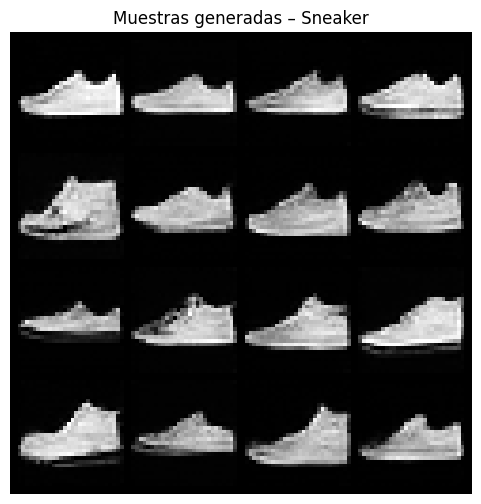

In [32]:
# Sampling: reconstrucción iterativa desde ruido puro (proceso inverso de DDPM)

@torch.no_grad()
def p_sample(model, x, t):
    # Extrae los coeficientes correspondientes al paso t para cada imagen del batch
    b = x.shape[0]
    betas_t = extract(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(sqrt_one_minus_alphas_cumprod, t, x.shape)
    sqrt_recip_alphas_t = extract(sqrt_recip_alphas, t, x.shape)
    """
    predecimos el ruido:
    Estima x_{t-1} aplicando la fórmula del proceso inverso (media del posterior)
    Usa el ruido predicho por la red para "deshacer" parcialmente el difuminado
    """
    model_mean = sqrt_recip_alphas_t * (x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t)

    # En t = 0 ya no se agrega ruido, la muestra final es determinista
    if (t == 0).all():
        return model_mean
    else:
        # Varianza del posterior q(x_{t-1} | x_t, x_0)
        posterior_var_t = extract(posterior_variance, t, x.shape)
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_var_t) * noise

@torch.no_grad()
def p_sample_loop(model, shape, n_steps=T):
    # Comienza desde ruido gaussiano
    img = torch.randn(shape, device=device)
    model.eval()
    # Recorre t = T-1, ..., 0 aplicando el paso inverso en cada iteración
    for i in reversed(range(0, n_steps)):
        t = torch.full((shape[0],), i, device=device, dtype=torch.long)
        img = p_sample(model, img, t)
    return img

@torch.no_grad()
def sample_and_show(model, n=16):
    # Genera n imágenes desde ruido y las muestra en una cuadrilla (grilla)
    samples = p_sample_loop(model, (n,1,28,28))
    grid = vutils.make_grid(samples, nrow=4, normalize=True, value_range=(-1,1))
    plt.figure(figsize=(6,6)); plt.axis("off"); plt.imshow(grid.permute(1,2,0).cpu()); plt.title(f"Muestras generadas – {CLASS_NAMES[CLASS_ID]}")
    plt.show()


# Ejecutar ejemplo de muestreo
sample_and_show(model, n=16)


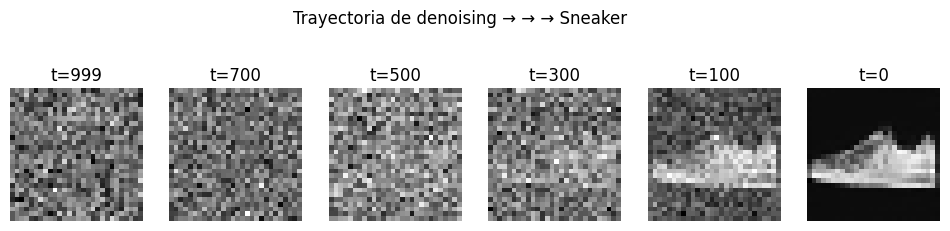

In [33]:
# Visualizar trayectoria de denoising para 1 imagen
@torch.no_grad()
def denoise_trajectory(model, steps_to_show=(299, 200, 120, 60, 20, 0)):
    # Parte desde ruido gaussiano
    img = torch.randn((1,1,28,28), device=device)
    imgs = {}
    model.eval()
    # Recorre t = T-1, ..., 0 y guarda ciertas etapas intermedias
    for i in reversed(range(0, T)):
        t = torch.full((1,), i, device=device, dtype=torch.long)
        img = p_sample(model, img, t)
        # Almacenamos copias de los pasos de interés
        if i in steps_to_show:
            imgs[i] = img.detach().clone().cpu()
    return imgs

# Selecciona fracciones del proceso para visualizar
steps = (T-1, int(T*0.7), int(T*0.5), int(T*0.3), int(T*0.1), 0)
traj = denoise_trajectory(model, steps_to_show=steps)

# Muestra la trayectoria en una grilla
fig, axs = plt.subplots(1, len(steps), figsize=(12,3))
for j, s in enumerate(steps):
    axs[j].imshow(traj[s][0,0], cmap="gray")
    axs[j].axis('off'); axs[j].set_title(f"t={s}")
plt.suptitle(f"Trayectoria de denoising → → → {CLASS_NAMES[CLASS_ID]}")
plt.show()

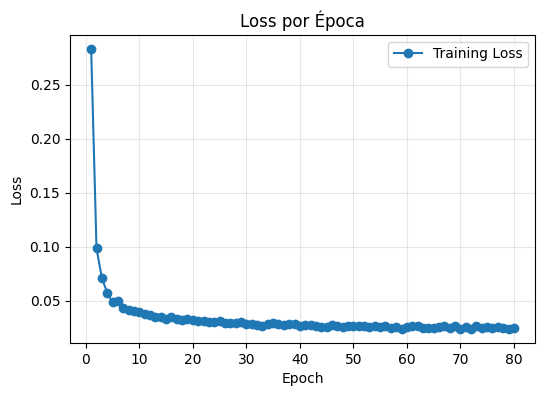

In [10]:
# Visualizar funcion de perdida por epoch
plt.figure(figsize=(6,4))
plt.plot(range(1, len(loss_epoch_hist)+1), loss_epoch_hist, label="Training Loss", marker='o')
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Loss por Época")
plt.legend(); plt.grid(True, alpha=0.3)
plt.show()

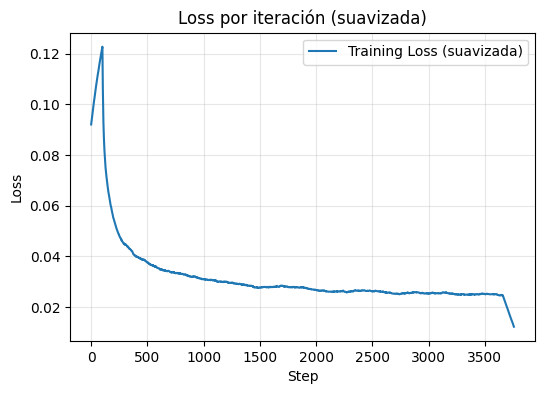

In [11]:
# Mas suave
def smooth(y, k=5):
    k = max(1, k)
    filt = np.ones(k)/k
    return np.convolve(y, filt, mode='same')
plt.figure(figsize=(6,4))
plt.plot(smooth(loss_step_hist, k=200), label="Training Loss (suavizada)")
plt.xlabel("Step"); plt.ylabel("Loss"); plt.title("Loss por iteración (suavizada)")
plt.legend(); plt.grid(True, alpha=0.3); plt.show()